Use  manual Linear Regression alg on a CAPM problem. 1- Pick your stock, use any large, popular index as your "market" value. 2- Scale your variables, 

$$
E R_i=R_f+\beta_i\left(E R_m-R_f\right)
$$
where:
$E R_i=$ expected return of investment
$R_f=$ risk-free rate
$\beta_i=$ beta of the investment
$\left(E R_m-R_f\right)=$ market risk premium

In [21]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Packages Importing
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy import stats




In [29]:
##########################################

start_date = dt.datetime(2018,1,1)
end_date = dt.datetime(2023,12,1)

tickers = ['CSCO', 'SQ', 'TSLA', 'DIS', 'SPY']
stock_tickers = ['CSCO', 'SQ', 'TSLA', 'DIS']
yf.pdr_override()
stocks_df = yf.download(tickers, start_date, end_date)

stocks_df = stocks_df.iloc[:, stocks_df.columns.get_level_values(0)=='Adj Close']
stocks_df.columns = stocks_df.columns.droplevel(0)

[*********************100%***********************]  5 of 5 completed


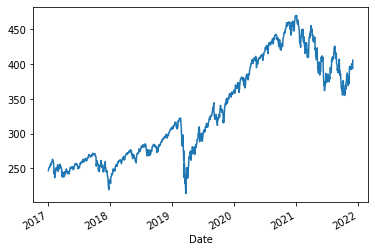

In [20]:
stocks_df['SPY'].plot()

In [21]:
#Normalise data
def scale(df):
  """
  When scaling you need to take the column array X and make all values x be: x = (x-mean(X))/std(X)
  """
  df_ = df.copy()
  for i in df_.columns[0:]:
    df_[i] = (df_[i]-df_[i].mean())/df_[i].std()
  return df_

# # returns 
def daily_retruns(df):
  df_ = df.copy()
  rs = (df_/df_.shift(1))-1 
  rs = rs.dropna()
  return rs


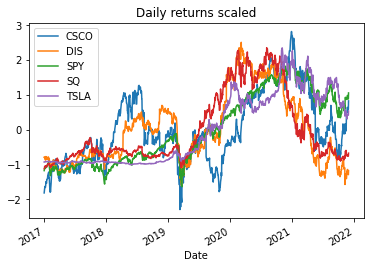

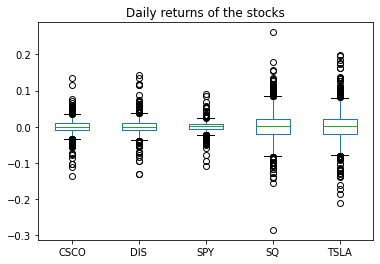

{'CSCO': 0.12547738827707525, 'DIS': 0.12660878797739877, 'SQ': 0.16729969013878565, 'TSLA': 0.14556949638659727}
0.14123884069496423


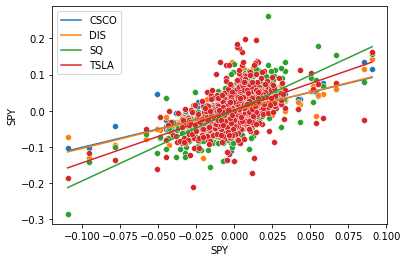

In [22]:
scaled_df = scale(stocks_df).dropna(axis=1)
scaled_df.plot()
plt.title('Daily returns scaled')
plt.show()

daily_ret_df = daily_retruns(stocks_df) 
daily_ret_df.boxplot( grid=False)
plt.title("Daily returns of the stocks")
plt.show()

beta = {}
alpha = {}
#regression method
LINEAR = False
NUMPY = True
STATS = False


#add flag for which regression to use
if NUMPY:
  for i in daily_ret_df.columns:
    if i != 'SPY' and i != 'Date':
      beta[i], alpha[i] = np.polyfit(daily_ret_df['SPY'], daily_ret_df[i], 1)
      sns.lineplot( x = daily_ret_df['SPY'], y = beta[i] * daily_ret_df['SPY'] + alpha[i], label = str(i))
      sns.scatterplot( x = daily_ret_df['SPY'], y = daily_ret_df[i], legend = 'full')
if STATS:
  for i in daily_ret_df.columns: 
    if i != 'SPY' and i != 'Date':
      LR = stats.linregress(daily_ret_df['SPY'],daily_ret_df[i])
      beta[i], alpha[i] = LR[0],LR[1]
      sns.lineplot( x = daily_ret_df['SPY'], y = beta[i] * daily_ret_df['SPY'] + alpha[i], label = str(i))
      sns.scatterplot( x = daily_ret_df['SPY'], y = daily_ret_df[i], legend = 'full')

keys = list(beta.keys())

#aclucalte average daily returns of market
annual = daily_ret_df['SPY'].mean() *252
rfr = 0.08
ER = {}

for i in keys:
  ER[i] = rfr + beta[i] *(annual-rfr)
print(ER)


portfolio_weights = 1/len(stock_tickers) * np.ones(len(stock_tickers)) 
ER_portfolio = sum(list(ER.values()) * portfolio_weights)
print(ER_portfolio)

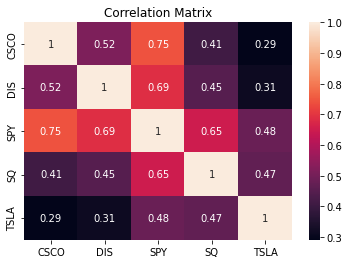

In [23]:
heat_corr=daily_ret_df.corr()
sns.heatmap(heat_corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [24]:
def grad_lin_reg(learning rate = 0.001, epoch = 2000, w, x,y):
  n = len(x)
  linear_loss=[]

  for i in range(epoch):
    
    y_predicted = np.dot(w.T,x)
    
    # w = w - learning_rate * (1/n) * (x.T*(x*w.T-y))
    w = w - learning_rate * (1/n) * np.dot(x,(y_predicted-y).T)
    linear_loss.append( ((y_predicted-y)**2 ).sum(axis=1))

    return w

SyntaxError: ignored

Arbitrage Pricing Theory (APT) - use betas

The CAPM suffers from several limitations, such as the use of a mean-variance framework and the fact that returns are captured by one risk factor-the market risk factor. In a well-diversified portfolio, the unsystematic risk of various stocks cancels out and is essentially eliminated.

The Arbitrage Pricing Theory (APT) model was put forward to address these shortcomings and offers a general approach of determining the asset prices other than the mean and variances.
The APT model assumes that the security returns are generated according to multiple factor models, which consist of a linear combination of several systematic risk factors. Such factors could be the inflation rate, GDP growth rate, real interest rates, or dividends.

The equilibrium asset pricing equation according to the APT model is as follows:
$$
E\left[R_i\right]=\alpha_i+\beta_{i, 1} F_1+\beta_{i, 2} F_2+\cdots+\beta_{i, j} F_j
$$

Here, $E\left[R_i\right]$ is the expected rate of return on security $i, \alpha_i$ is the expected return on stock $i$ if all factors are negligible, $\beta_{i, j}$ is the sensitivity of the $i_{\text {th }}$ asset to the $j$ th factor, and $F_j$ is the value of the $j_{\text {th }}$ factor influencing the return on stock $i$.

Since our goal is to find all values of $\alpha_i$ and $\beta$, we will perform a multivariate linear regression on the APT model.

In [25]:
!pip install fredapi



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The risk free rate 3-Month Treasury Constant Maturity Rate is used

Text(0.5, 1.0, 'Risk free Treasury Constant Maturity Rate')

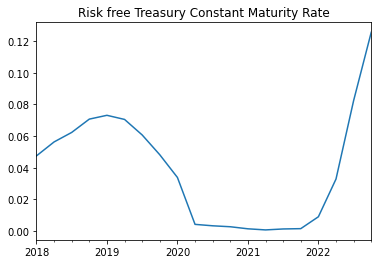

In [30]:
from fredapi import Fred
fred = Fred(api_key="112a0343bfd607b884218e72fb36894b")

#RFR
fred.search('risk free')
risk_free=fred.get_series('GS3M')
risk_free=risk_free[start_date:end_date]
rf=risk_free/100
#convert to quartely interst rate
rf=rf.resample('Q').mean()*3
rf.plot()
plt.title("Risk free Treasury Constant Maturity Rate")

Text(0.5, 1.0, 'GDP growth')

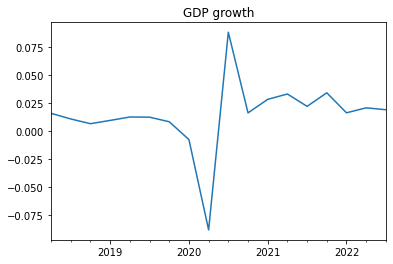

In [31]:
#GDP
gdp=fred.get_series('GDP')
gdp=gdp[start_date:end_date]
#calculate gdp growth
gdp_growth=gdp.pct_change().dropna()
gdp_growth.plot()
plt.title("GDP growth")

Text(0.5, 1.0, 'Inflation')

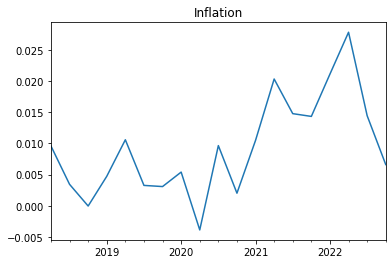

In [35]:
#Inflation
fred.search('potential inflation')
inf=fred.get_series('CPIEALL')
inf=inf[start_date:end_date]
inf_quarterly = inf.resample('Q').mean()
inf_growth=inf_quarterly.pct_change().dropna()
inf_growth.plot()
plt.title("Inflation")